# **GWAS tutorial**

In [2]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

## ChiSquare vs Fisher

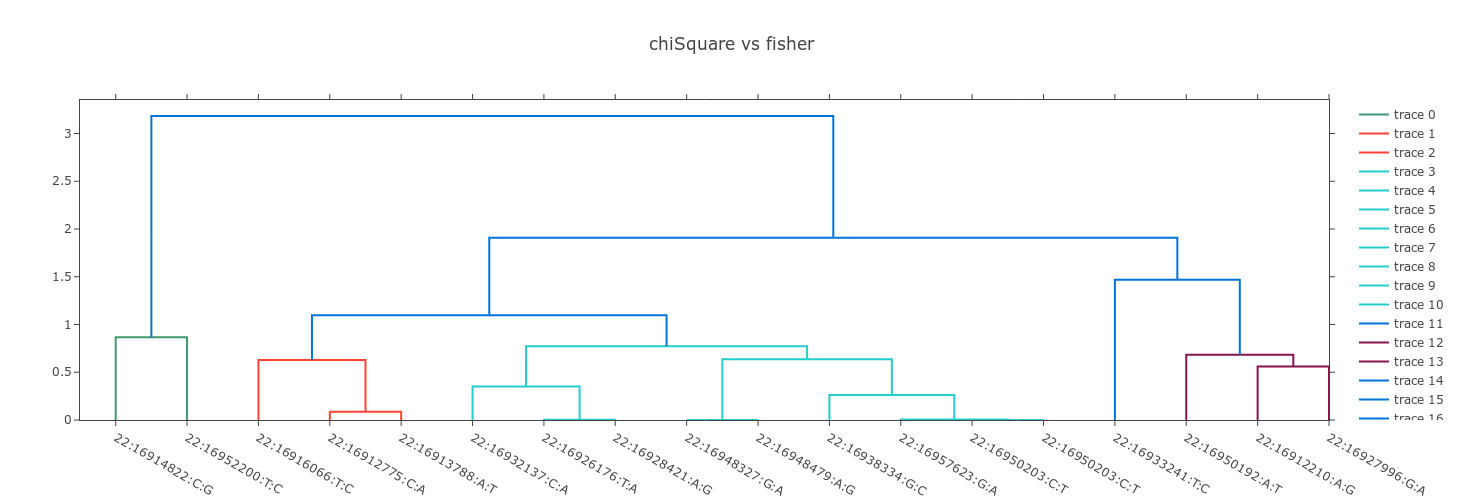

In [2]:
import numpy as np
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.offline import get_plotlyjs, init_notebook_mode

init_notebook_mode(connected=True)

statsDF = oskar.stats(df, studyId="hgvauser@platinum:illumina_platinum", missingAsReference=True)
dfSLC = statsDF.filter(array_contains(genes("annotation"), "SLC9B1P4"))

pandasFisher = oskar.fisher(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
pandasChiSquare = oskar.chiSquare(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

labels=pandasFisher["id"].tolist()

dim = len(labels)
X = np.zeros((dim, dim))
for i in range(dim):
    for j in range(i, dim):
        X[i, j] = np.absolute(pandasFisher["fisher"][i] - pandasFisher["fisher"][j])
for i in range(dim):
    for j in range(i, dim):
        X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

fig = ff.create_dendrogram(X, labels=labels, color_threshold=1)
fig['layout'].update({'width':1440, 'height':500, 'showlegend':True, "title":"chiSquare vs fisher"})
py.iplot(fig, filename='dendrogram')

## ChiSquare

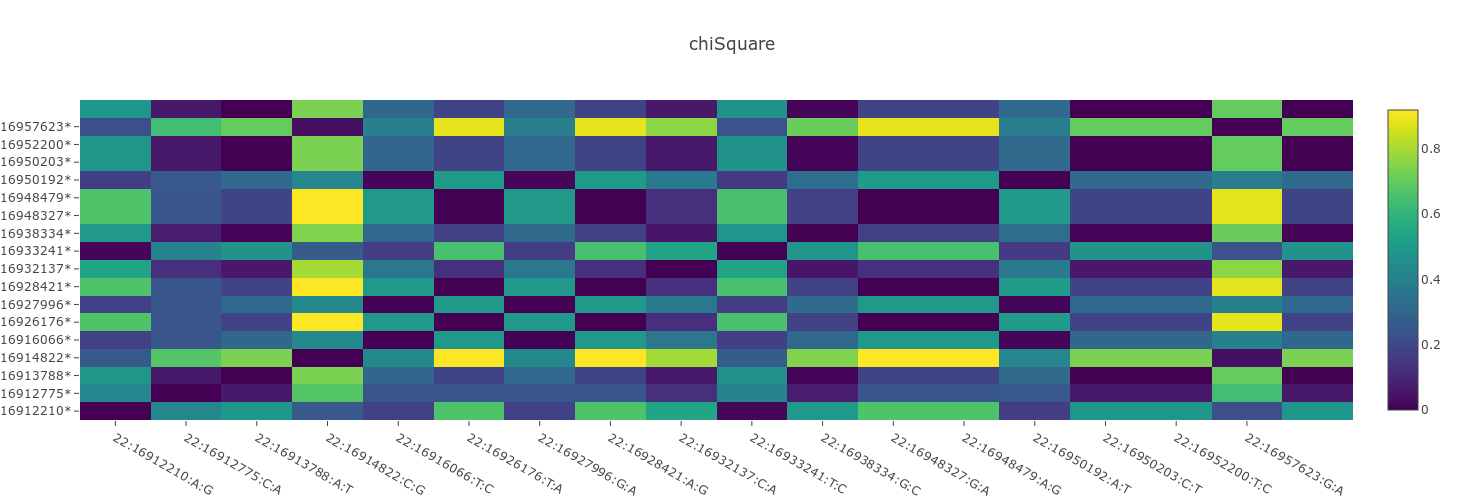

In [4]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import get_plotlyjs, init_notebook_mode

init_notebook_mode(connected=True)

statsDF = oskar.stats(df, studyId="hgvauser@platinum:illumina_platinum", missingAsReference=True)
dfSLC = statsDF.filter(array_contains(genes("annotation"), "SLC9B1P4"))

pandasFisher = oskar.fisher(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
pandasChiSquare = oskar.chiSquare(dfSLC, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

labels=pandasFisher["id"].tolist()
labelsPosition=[i.split(':', 3)[1] + "*" for i in labels]

dim = len(labels)
X = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

trace = go.Heatmap(x=labels, y=labelsPosition, z=X, colorscale='Viridis')
fig = go.Figure(data=[trace])
fig['layout'].update({'width':1440, 'height':500, 'title':'chiSquare'})
py.iplot(fig, filename='annotated_heatmap_color')